In [1031]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1032]:
data_dir = r"C:\Users\Adam\Data\Lisa\platelets\Platelet data 2018-05-12"

quickly define two helper functions - find_files, to find files recursively within a directory & subdirectories, and csv_list_to_dataframe, which loads dataframes and returns a concatenated output

In [1033]:
def find_files( data_dir, pattern ):
    """
    helper function to find files within a directory structure
    arguments: 
        string data_dir: path to directory to be searched (including subdirs)
        string pattern: string to find in filenames
        
    returns:
        list results: list of string paths to files with names containing string 'pattern'
    """
    results = []
    for root, dirs, files in os.walk(data_dir):
        for file in files: # loops through directories and files
            if pattern in file: # compares to your specified conditions
                results.append( os.path.join(root,file))
    return results

def csv_list_to_dataframe( csv_list ):
    """
    helper function to load and concatenate dataframes
    arguments: 
        list csv_list: list of path+filename strings to be loaded
        
    returns:
        dataframe : concatenated results
    """
    df_list = []
    for file in csv_list:
        df =  pd.read_csv(file)
        df['Source'] = file
        df.columns = [c.lstrip('0123456789_').strip('_') for c in df.columns]
        for c in df.columns:
            if '.1' in c:
                print(file)
                print(c)
            if c[-1] =='_':
                print(file)
                print(c)
        df_list.append( df )
    return pd.concat( df_list )
        

In [1034]:
# find and load data
file_list = find_files(data_dir, '.csv')
df = csv_list_to_dataframe( file_list )

# Extract some misc info from the filename
df['Replicate Number'] = df['Source'].str.extract(r"Rep ([0-9])", expand = False).astype(int)

df['Fraction'] = df['Source'].str.extract(r"(supe|pellet)", expand = False)
df['Mode'] = df['Source'].str.extract(r"(pos|neg)", expand = False)
df['Treatment'] = df['Source'].str.extract(r"(activated|blank|hsd1|hsd2)", expand = False)

In [1035]:
# dump un-needed columns, specifically 'dilution', 'repeat' and 'NEW'.  I don't know what they are
df = df[ [c for c in df.columns if ( ('dil' not in c) & ('repeat' not in c) & ('NEW' not in c) )]]

In [1036]:
df = df.drop_duplicates(subset=['Source','compound'], keep = 'first')

In [1037]:
for c in df.columns:
    print(c)

Source
activated_pellet_a_neg
activated_pellet_a_pos
activated_pellet_b_neg
activated_pellet_b_pos
activated_supe_a_neg
activated_supe_a_pos
activated_supe_b_neg
activated_supe_b_pos
blank_mid_a_neg
blank_mid_a_pos
blank_mid_b_neg
blank_mid_b_pos
blank_post_a_neg
blank_post_a_pos
blank_post_b_neg
blank_post_b_pos
blank_pre_a_neg
blank_pre_a_pos
blank_pre_b_neg
blank_pre_b_pos
blank_pre_c_neg
blank_pre_c_pos
buffer_pellet_a_neg
buffer_pellet_a_pos
buffer_pellet_b_neg
buffer_pellet_b_pos
buffer_supe_a_neg
buffer_supe_a_pos
buffer_supe_b_neg
buffer_supe_b_pos
compound
compoundId
expectedRtDiff
goodPeakCount
groupId
hsd1_pellet_a_neg
hsd1_pellet_a_pos
hsd1_pellet_b_neg
hsd1_pellet_b_pos
hsd1_supe_a_neg
hsd1_supe_a_pos
hsd1_supe_b_neg
hsd1_supe_b_pos
hsd2_pellet_a_neg
hsd2_pellet_a_pos
hsd2_pellet_b_neg
hsd2_pellet_b_pos
hsd2_supe_a_neg
hsd2_supe_a_pos
hsd2_supe_b_neg
hsd2_supe_b_pos
label
maxQuality
medMz
medRt
metaGroupId
non_pellet_a_neg
non_pellet_a_pos
non_pellet_b_neg
non_pellet_b_pos

In [1139]:
# a quick check to see how many compounds show up in all replicates
df.groupby(['compound']).apply(lambda x: len(x['Replicate Number'].unique())).value_counts()

1    250
2    154
3     66
dtype: int64

c:\users\adam\anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


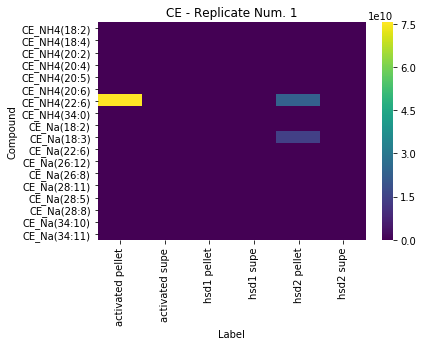

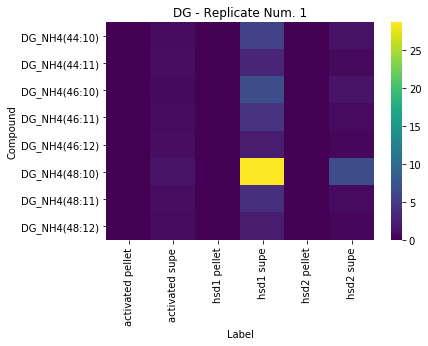

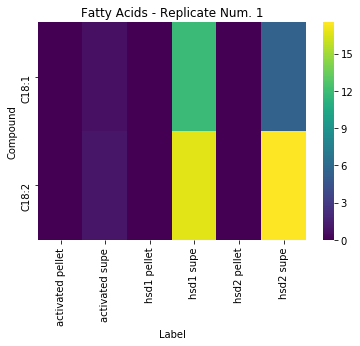

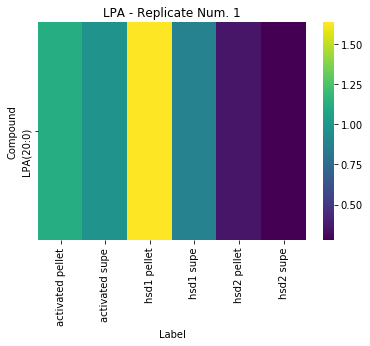

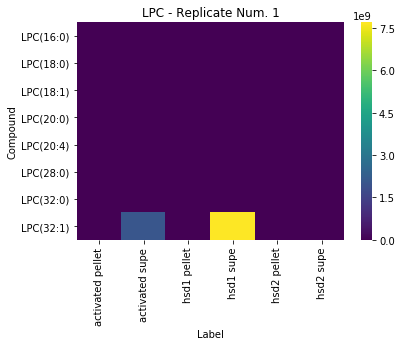

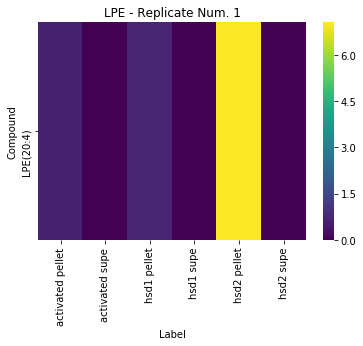

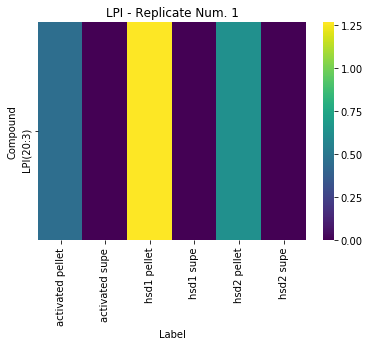

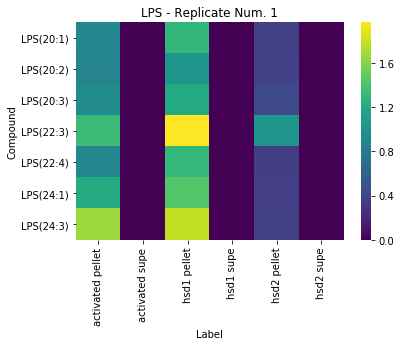

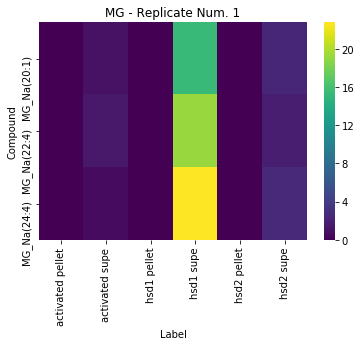

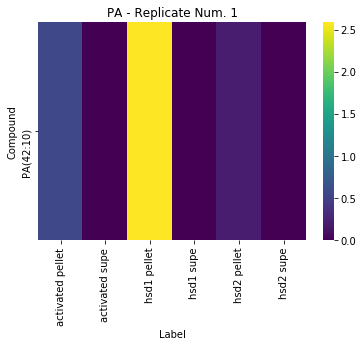

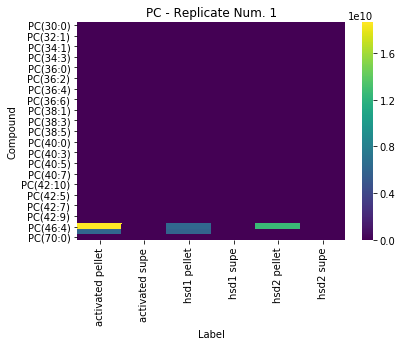

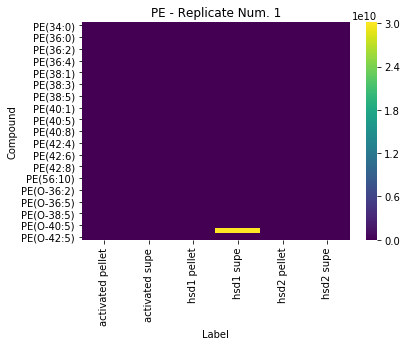

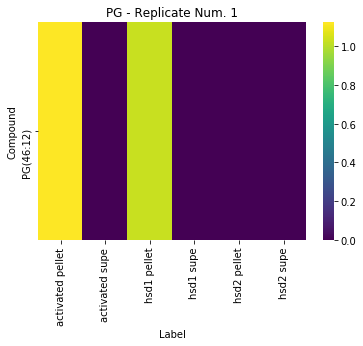

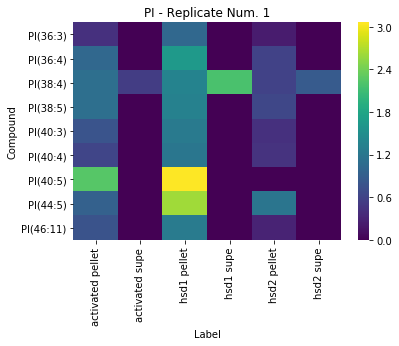

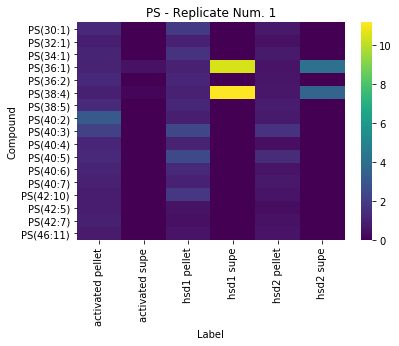

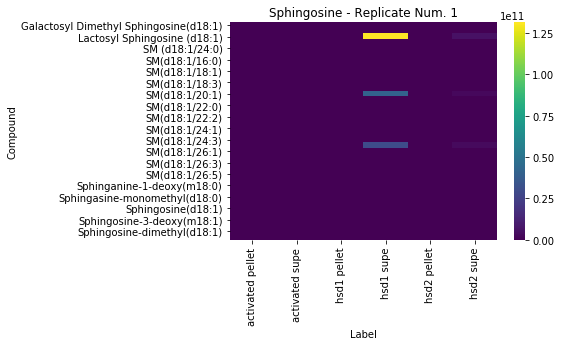

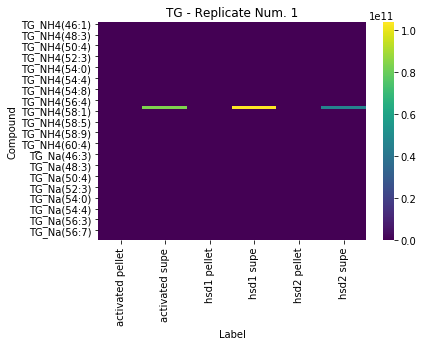

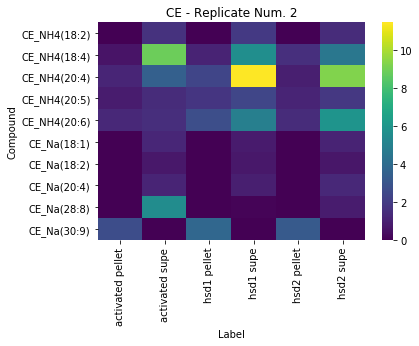

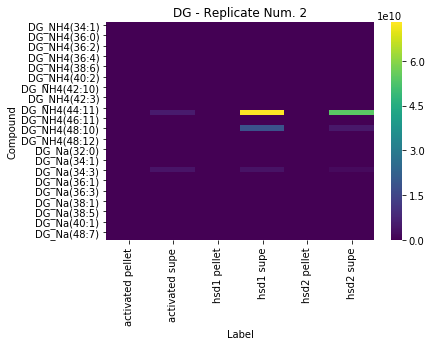

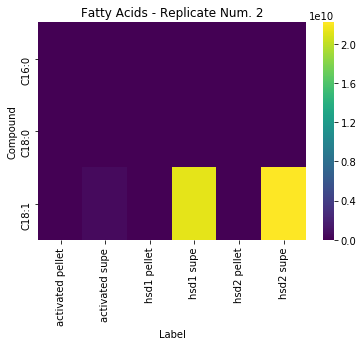

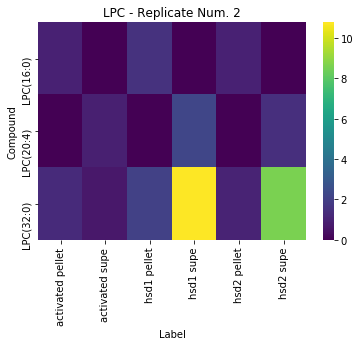

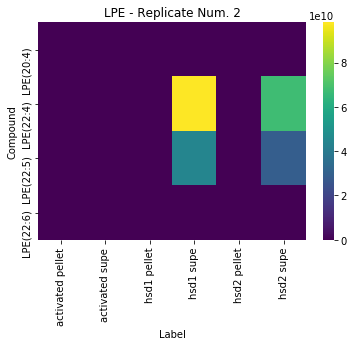

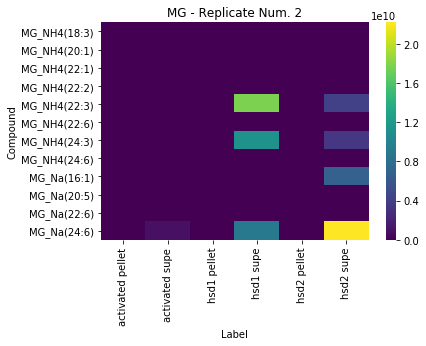

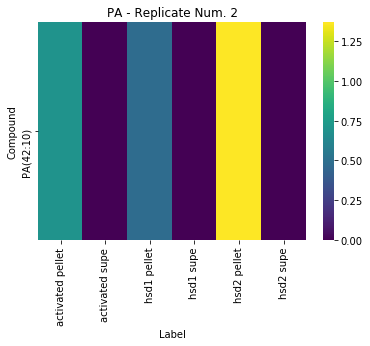

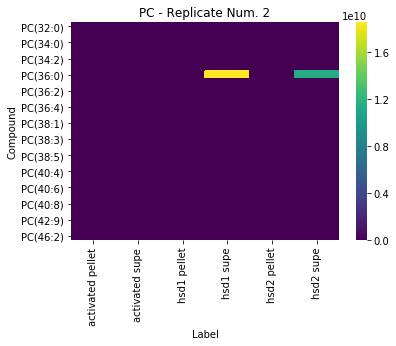

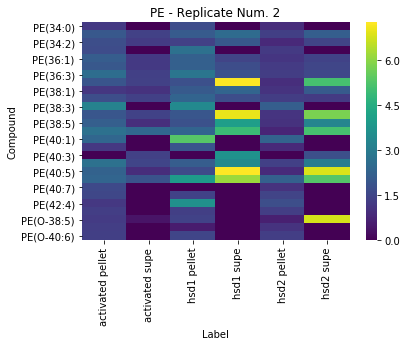

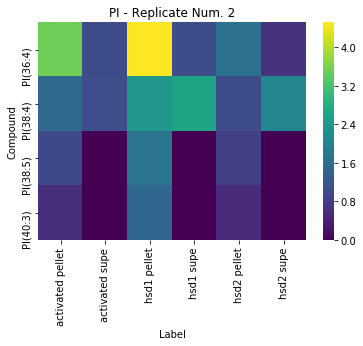

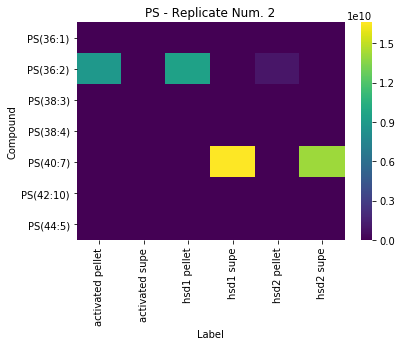

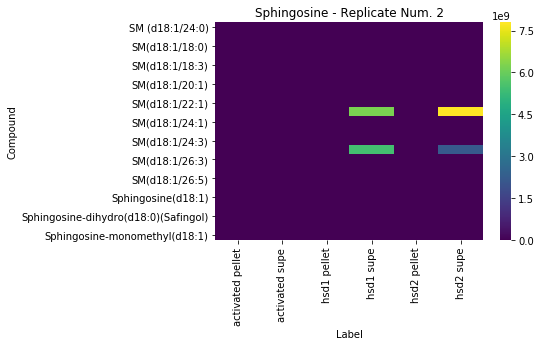

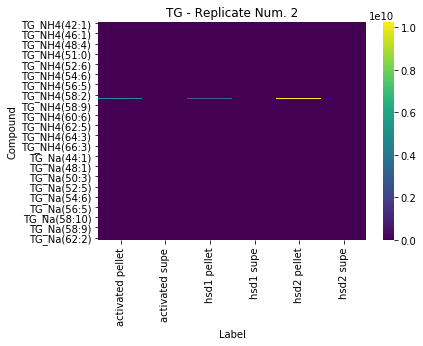

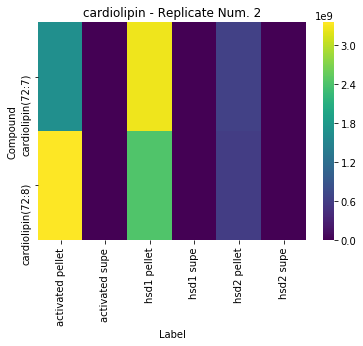

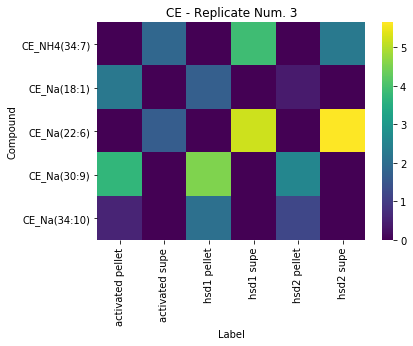

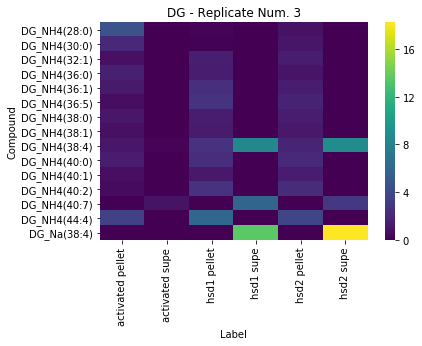

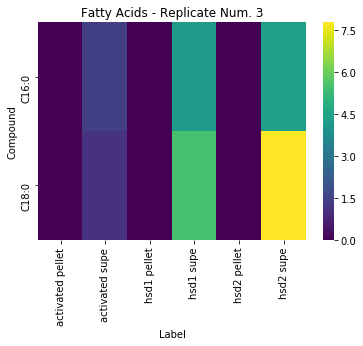

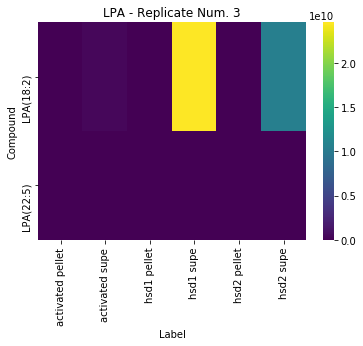

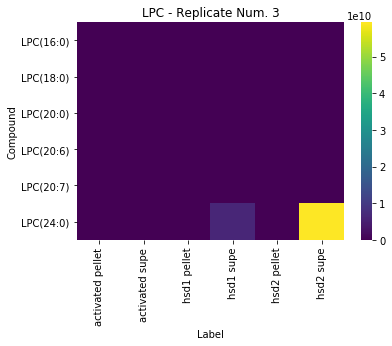

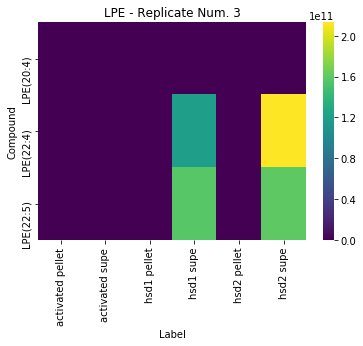

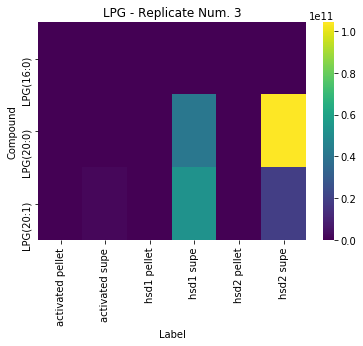

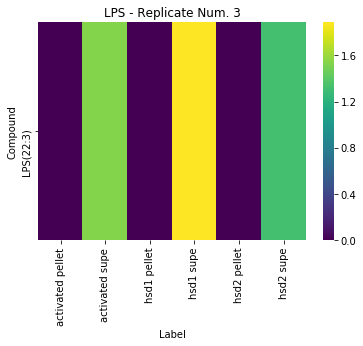

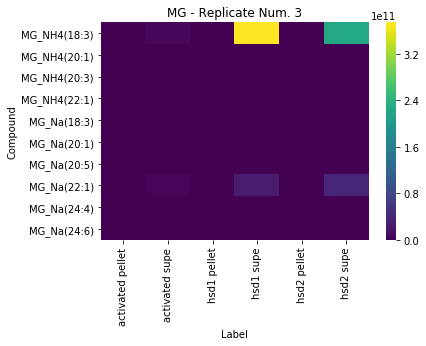

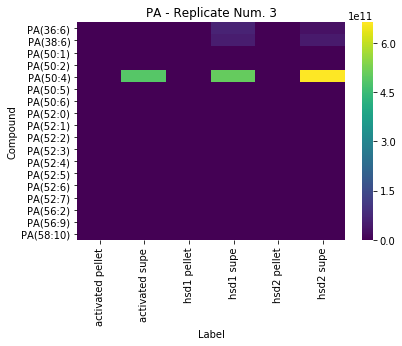

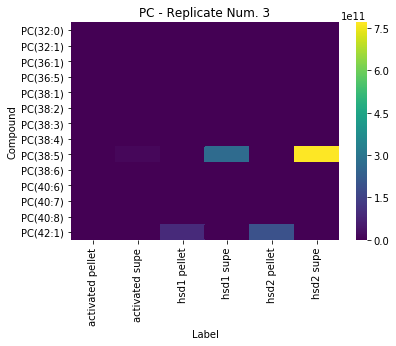

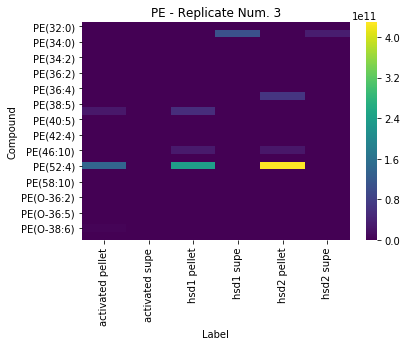

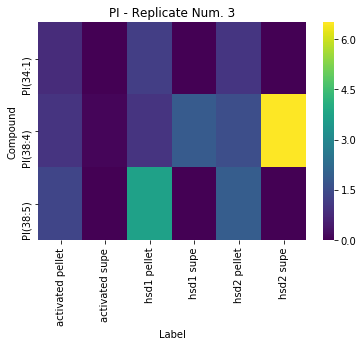

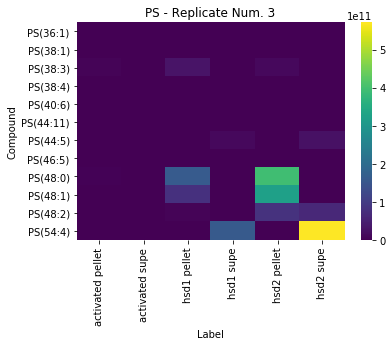

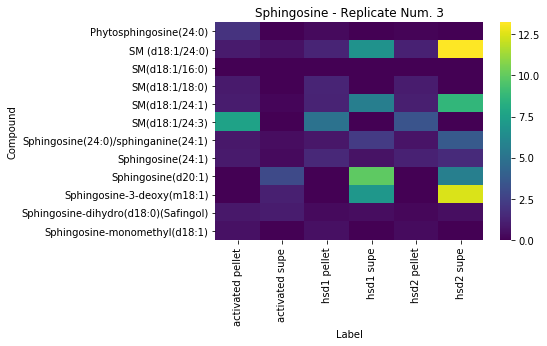

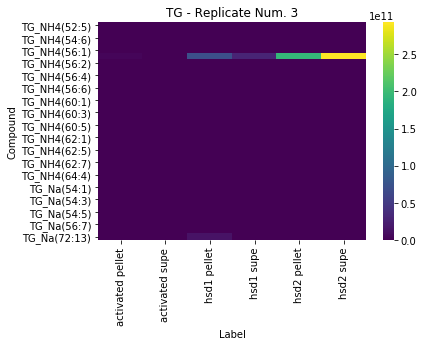

In [1184]:
for rep_num in [1,2,3]:
    results = []

    for lbl, grp in df[ (df['Replicate Number'] == rep_num)  ].groupby(['compound']):

        data = grp[ [c for c in grp.columns if '_' in c] ].T.copy().fillna(0).max(axis=1)
        data = data.reset_index()

        data['Fraction'] = data['index'].str.extract(r"(supe|pellet|blank)", expand = False)
        data['Mode'] = data['index'].str.extract(r"(pos|neg)", expand = False)
        data['Treatment'] = data['index'].str.extract(r"(activated|blank|hsd1|hsd2|non|buffer)", expand = False)
        data['Subsample'] = data['index'].str.extract(r"_([ab])_", expand = False)

        for index,row in data.fillna(0).iterrows():

            if row['Treatment'] in ['non','blank','buffer']:
                continue

            ref = data[ (data['Fraction'] == row['Fraction']) & 
                       (data['Treatment'] == 'non') &
                      (data['Mode'] == row['Mode']) &
                      (data['Subsample'] == row['Subsample'])][data.columns[1]].fillna(0).iloc[0]

            f = row[data.columns[1]] / (ref + 0.000001 )

            # figure out the head group
            if ':' in lbl.split('(')[0]:
                head_group = 'Fatty Acids'
            elif ( ('sphing' in lbl.lower()) or ('SM' in lbl) ):
                head_group = 'Sphingosine'
            else:
                head_group = lbl.split('(')[0].split('_')[0]

            results.append({'Compound' : lbl,
                            'Index' : index,
                            'Ref' : ref,
                            'Fold Change' : f,
                            'Label' : row['Treatment'] + ' ' + row['Fraction'],
                            'Sample' : row['index'][-5],
                            'Fraction' : row['Fraction'],
                           'Mode': row['Mode'],
                            'Head Group': head_group,
                            'Signal' : row[data.columns[1]],
                           'Treatment': row['Treatment']})

    results = pd.DataFrame(results)

    for lbl, grp in results.groupby('Head Group'):

        plt.figure()
        plt.grid(color = 'white')

        d = grp.groupby(['Compound','Label','Sample'])['Fold Change'].max().reset_index()\
        .groupby(['Compound','Label'])['Fold Change'].mean().reset_index()

        sns.heatmap( d.pivot( index = 'Compound', values = 'Fold Change', columns = 'Label'), cmap = 'viridis' )
        plt.title("{} - Replicate Num. {}".format(lbl, rep_num) )
        
plt.show()

In [1185]:
grp = df[ (df['Replicate Number']==1) & (df['compound']=='PE(36:1)')]
data = grp[ [c for c in grp.columns if '_' in c] ].T.copy().fillna(0).max(axis=1)
data = data.reset_index()
data

,index,0
0,activated_pellet_a_neg,0.000
1,activated_pellet_a_pos,402962.800
2,activated_pellet_b_neg,0.000
3,activated_pellet_b_pos,381102.600
4,activated_supe_a_neg,0.000
5,activated_supe_a_pos,0.000
6,activated_supe_b_neg,0.000
7,activated_supe_b_pos,0.000
8,blank_mid_a_neg,0.000
9,blank_mid_a_pos,12642.040
